# AML Group Project Group 11

## Group Members:

*   Feiyang Zhu (fz2356)
*   Malik Javaid (maj2187)
*   Max Mason (mmm2491)
*   Zhehong Fu (zf2307)
*   Zhiyi Li (zl2740)


## Data Preprocessing

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import io
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.metrics import f1_score
from google.colab import files
import time
from scipy.stats import randint

Dataset Resource:

    
    https://www.kaggle.com/datasets/rohitudageri/credit-card-details.

Read and Join Datasets:

In [ ]:
# Read Data
credit_label_df = pd.read_csv('Credit_card_label.csv')
credit_feature_df = pd.read_csv('Credit_card.csv')

# Merge Data
credit_df = credit_feature_df.merge(credit_label_df, on='Ind_ID')
credit_df = credit_df.set_index(credit_df.columns[0])

credit_df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
Ind_ID,,,,,,,,,,,,,,,,,,
5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0


Overall Label Distribution:

Text(0, 0.5, 'Frequency')

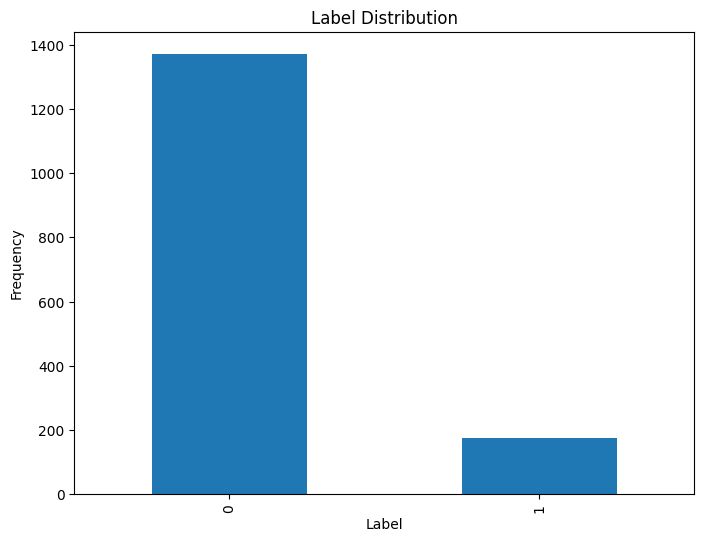

In [ ]:
ax = credit_df['label'].value_counts().plot(kind='bar',
                                    figsize=(8,6),
                                    title="Label Distribution")
ax.set_xlabel("Label")
ax.set_ylabel("Frequency")

Preprocessing:

In [ ]:
# Handle NaN Values

# Count
nans = credit_df.isna().sum()
missing_cols = nans[nans != 0]
missing_cols.sort_values(ascending=False)
missing_cols

GENDER               7
Annual_income       23
Birthday_count      22
Type_Occupation    488
dtype: int64

In [ ]:
# Drop Columns
credit_df_cleaned = credit_df.drop(columns=['Type_Occupation', 'Mobile_phone'])
# Drop Rows
credit_df_cleaned = credit_df_cleaned.dropna(subset=['GENDER', 'Annual_income', 'Birthday_count'])

# Check for Deletion
nans = credit_df_cleaned.isna().sum()
missing_cols = nans[nans != 0]
missing_cols.sort_values(ascending=False)
missing_cols

Series([], dtype: int64)

In [ ]:
# Convert Employed Days
credit_df_cleaned['Employment_Status'] = np.where(credit_df_cleaned['Employed_days'] >= 0, 0, 1)
credit_df_cleaned = credit_df_cleaned.drop(columns=['Employed_days'])
credit_df_cleaned

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Work_Phone,Phone,EMAIL_ID,Family_Members,label,Employment_Status
Ind_ID,,,,,,,,,,,,,,,,
5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,0,0,0,2,1,0
5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,1,1,0,2,1,1
5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,1,1,0,2,1,1
5009754,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,1,1,0,2,1,1
5009894,F,N,N,0,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22134.0,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5118268,M,Y,N,1,360000.0,State servant,Secondary / secondary special,Married,House / apartment,-11294.0,0,1,0,3,0,1
5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,0,0,0,1,0,1
5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,0,0,0,4,0,1


In [ ]:
# Convert Birthday Count
credit_df_cleaned['Age'] = (credit_df_cleaned['Birthday_count'] * -1) // 365
credit_df_cleaned = credit_df_cleaned.drop(columns=['Birthday_count'])
credit_df_cleaned

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Work_Phone,Phone,EMAIL_ID,Family_Members,label,Employment_Status,Age
Ind_ID,,,,,,,,,,,,,,,,
5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,0,0,0,2,1,0,51.0
5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,1,1,0,2,1,1,37.0
5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,1,1,0,2,1,1,37.0
5009754,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,1,1,0,2,1,1,37.0
5009894,F,N,N,0,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,2,1,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5118268,M,Y,N,1,360000.0,State servant,Secondary / secondary special,Married,House / apartment,0,1,0,3,0,1,30.0
5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,0,0,0,1,0,1,28.0
5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,0,0,0,4,0,1,36.0


Heatmap:

<Axes: >

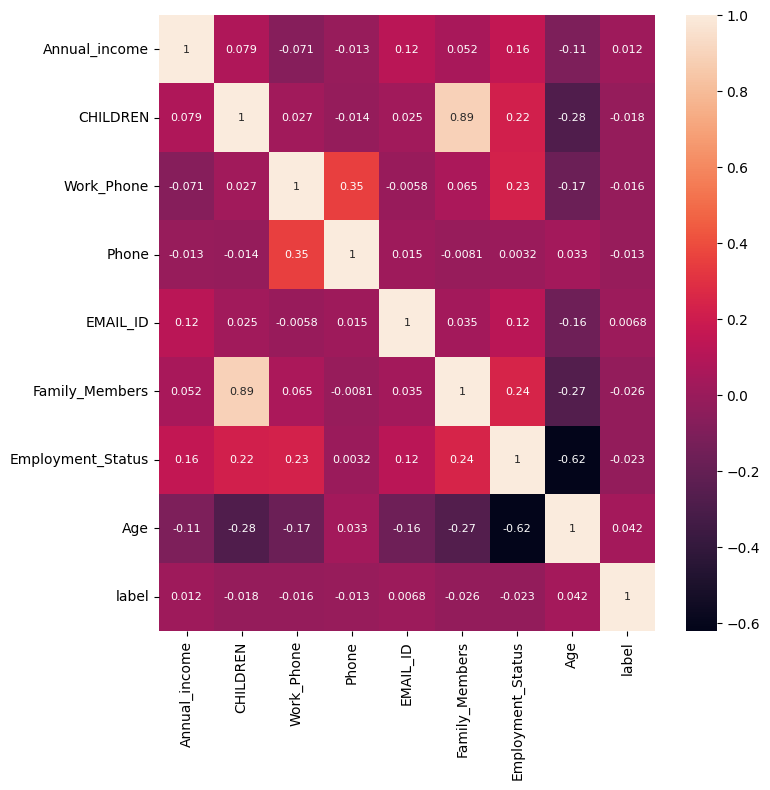

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(credit_df_cleaned[['Annual_income', 'CHILDREN', 'Work_Phone', 'Phone', 'EMAIL_ID', 'Family_Members', 'Employment_Status', 'Age', 'label']].corr(), annot_kws={"size": 8}, annot = True)

In [ ]:
credit_df_cleaned.corrwith(credit_df_cleaned['label'])

<ipython-input-23-6454f44cd62f>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  credit_df_cleaned.corrwith(credit_df_cleaned['label'])


CHILDREN            -0.018079
Annual_income        0.012124
Work_Phone          -0.015733
Phone               -0.013015
EMAIL_ID             0.006809
Family_Members      -0.025955
label                1.000000
Employment_Status   -0.023394
Age                  0.041729
dtype: float64

In [ ]:
# further processing: drop family_member column, encode the categorical values
ord_enc = OrdinalEncoder()

credit_df_cleaned = credit_df_cleaned.drop(columns=['Family_Members'])
credit_df_cleaned[['Type_Income','EDUCATION','Marital_status','Housing_type','GENDER','Car_Owner','Propert_Owner']] = ord_enc.fit_transform(credit_df_cleaned[['Type_Income','EDUCATION','Marital_status','Housing_type','GENDER','Car_Owner','Propert_Owner']])

In [ ]:
credit_df_cleaned = credit_df_cleaned.reset_index(drop=True)
df_x = credit_df_cleaned.drop(columns=['label'])
df_y = credit_df_cleaned['label']

In [ ]:
# split into training (60%), validation (20%), and test (20%) sets.
x_train, x_tmp, y_train, y_tmp = train_test_split(df_x, df_y, test_size=0.4, stratify=df_y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

# Logistic Regression

Plain Vanilla Logistic Regression:

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)

print(f'Validation data accuracy:', lr.score(x_val, y_val))
print(f'Test data accuracy:', lr.score(x_test, y_test))

Validation data accuracy: 0.8929765886287625
Test data accuracy: 0.8933333333333333


In [ ]:
y_pred_lr = lr.predict(x_test)
print(f'Test data F-1 score:', f1_score(y_pred_lr, y_test))

Test data F-1 score: 0.0


We find good accuracy scores but an F-1 score of 0 means that we are predicting only negatives.

Hyperparameter Tuned Lasso Logistic Regression:

In [ ]:
pipeline = imb_make_pipeline(
    StandardScaler(),
    SMOTE(),
    LogisticRegression(random_state=42)
)


param_grid = {
    'logisticregression__C': np.logspace(-3, 3, 10),
    'logisticregression__penalty': ['l1'],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__max_iter': [100, 500, 1000, 5000, 10000]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

print(f"Best Parameters: {best_params}")
print(f'Validation data performance:', grid_search.score(x_val, y_val))
print(f'Test data performance:', grid_search.score(x_test, y_test))
print(f'Test data F-1 score:', f1_score(y_pred, y_test))

Best Parameters: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Validation data performance: 0.8929765886287625
Test data performance: 0.8933333333333333
Test data F-1 score: 0.0


Hyperparameter Tuned Ridge Logistic Regression:

In [ ]:
pipeline = imb_make_pipeline(
    StandardScaler(),
    SMOTE(),
    LogisticRegression(random_state=42)
)


param_grid = {
    'logisticregression__C': np.logspace(-3, 3, 10),
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 500, 1000, 5000, 10000]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

print(f"Best Parameters: {best_params}")
print(f'Validation data performance:', grid_search.score(x_val, y_val))
print(f'Test data performance:', grid_search.score(x_test, y_test))
print(f'Test data F-1 score:', f1_score(y_pred, y_test))

Best Parameters: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Validation data performance: 0.6220735785953178
Test data performance: 0.58
Test data F-1 score: 0.136986301369863


Hyperparameter Tuned Elastic Net Logistic Regression:

In [ ]:
pipeline = imb_make_pipeline(
    StandardScaler(),
    RandomOverSampler(),
    LogisticRegression(random_state=42)
)


param_grid = {
    'logisticregression__C': np.logspace(-3, 3, 10),
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__solver': ['saga'],
    'logisticregression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
    'logisticregression__max_iter': [100, 500, 1000, 5000, 10000]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

print(f"Best Parameters: {best_params}")
print(f'Validation data performance:', grid_search.score(x_val, y_val))
print(f'Test data performance:', grid_search.score(x_test, y_test))
print(f'Test data F-1 score:', f1_score(y_pred, y_test))

Best Parameters: {'logisticregression__C': 0.004641588833612777, 'logisticregression__l1_ratio': 0.25, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
Validation data performance: 0.6120401337792643
Test data performance: 0.5833333333333334
Test data F-1 score: 0.13793103448275862


We get improvements in the test F-1 score for some of the new models but we see a decrease in our models accuracy in the validation and test sets. In this hyperparameter tuning we tuned on accuracy as our scoring metric so no we'll see what happens when we do the same but tuning with f1-scores.

Lasso Logistic Regression (f1-score)

In [ ]:
pipeline = imb_make_pipeline(
    StandardScaler(),
    SMOTE(),
    LogisticRegression(random_state=42)
)


param_grid = {
    'logisticregression__C': np.logspace(-3, 3, 10),
    'logisticregression__penalty': ['l1'],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__max_iter': [100, 500, 1000, 5000, 10000]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

print(f"Best Parameters: {best_params}")
print(f'Validation data performance:', grid_search.score(x_val, y_val))
print(f'Test data F-1 score:', f1_score(y_pred, y_test))
print(f'Test data accuracy:', best_model.score(x_test, y_test))

Best Parameters: {'logisticregression__C': 0.021544346900318832, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Validation data performance: 0.2360248447204969
Test data F-1 score: 0.11560693641618498
Test data accuracy: 0.49


Ridge Logistic Regression (f1-score):

In [ ]:
pipeline = imb_make_pipeline(
    StandardScaler(),
    SMOTE(),
    LogisticRegression(random_state=42)
)


param_grid = {
    'logisticregression__C': np.logspace(-3, 3, 10),
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 500, 1000, 5000, 10000]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

print(f"Best Parameters: {best_params}")
print(f'Validation data performance:', grid_search.score(x_val, y_val))
print(f'Test data F-1 score:', f1_score(y_pred, y_test))
print(f'Test data accuracy:', best_model.score(x_test, y_test))

Best Parameters: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Validation data performance: 0.20915032679738563
Test data F-1 score: 0.11920529801324502
Test data accuracy: 0.5566666666666666


Elastic Net Logistic Regression (f1-score):

In [ ]:
pipeline = imb_make_pipeline(
    StandardScaler(),
    RandomOverSampler(),
    LogisticRegression(random_state=42)
)


param_grid = {
    'logisticregression__C': np.logspace(-3, 3, 10),
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__solver': ['saga'],
    'logisticregression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

print(f"Best Parameters: {best_params}")
print(f'Validation data performance:', grid_search.score(x_val, y_val))
print(f'Test data F-1 score:', f1_score(y_pred, y_test))
print(f'Test data accuracy:', best_model.score(x_test, y_test))

Best Parameters: {'logisticregression__C': 0.004641588833612777, 'logisticregression__l1_ratio': 0.25, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
Validation data performance: 0.24444444444444446
Test data F-1 score: 0.16574585635359115
Test data accuracy: 0.49666666666666665


# Decision Tree

Plain Vanilla Decision Tree:

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)

print(f'Validation data accuracy:', dt.score(x_val, y_val))
print(f'Test data accuracy:', dt.score(x_test, y_test))

Validation data accuracy: 0.8394648829431438
Test data accuracy: 0.85


In [ ]:
y_pred_dt = dt.predict(x_test)
print(f'Test data F-1 score:', f1_score(y_pred_dt, y_test))

Test data F-1 score: 0.4303797468354431


Extract Feature Importance:

<Axes: >

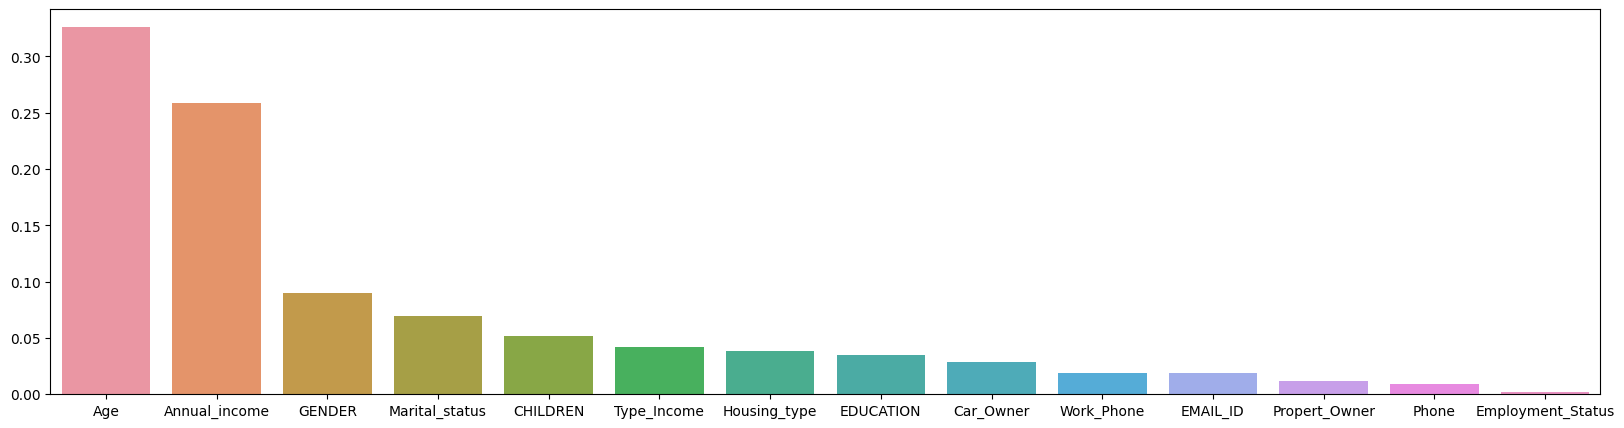

In [ ]:
features_dt = dt.feature_importances_
col_names = df_x.columns
idx = features_dt.argsort()[::-1]
fna = col_names[idx]
fim = features_dt[idx]

plt.figure(figsize=(20,5))
sns.barplot(y=fim, x=fna)

Add Hyperparameter Tuning:

In [ ]:
params_dt = {'max_depth': list(np.arange(10, 100, step=5))+[None],
             'max_features': randint(1, 9),
             'min_samples_leaf': randint(1, 9),
             'criterion':['gini','entropy']}

model_dt = RandomizedSearchCV(estimator=dt, param_distributions=params_dt, cv=5, scoring="f1")
model_dt.fit(x_train, y_train)

print(f'Validation data F-1 score:', model_dt.score(x_val, y_val))
print(f'Test data F-1 score:', model_dt.score(x_test, y_test))

Validation data F-1 score: 0.2456140350877193
Test data F-1 score: 0.4857142857142857


Extract Feature Importance:

<Axes: >

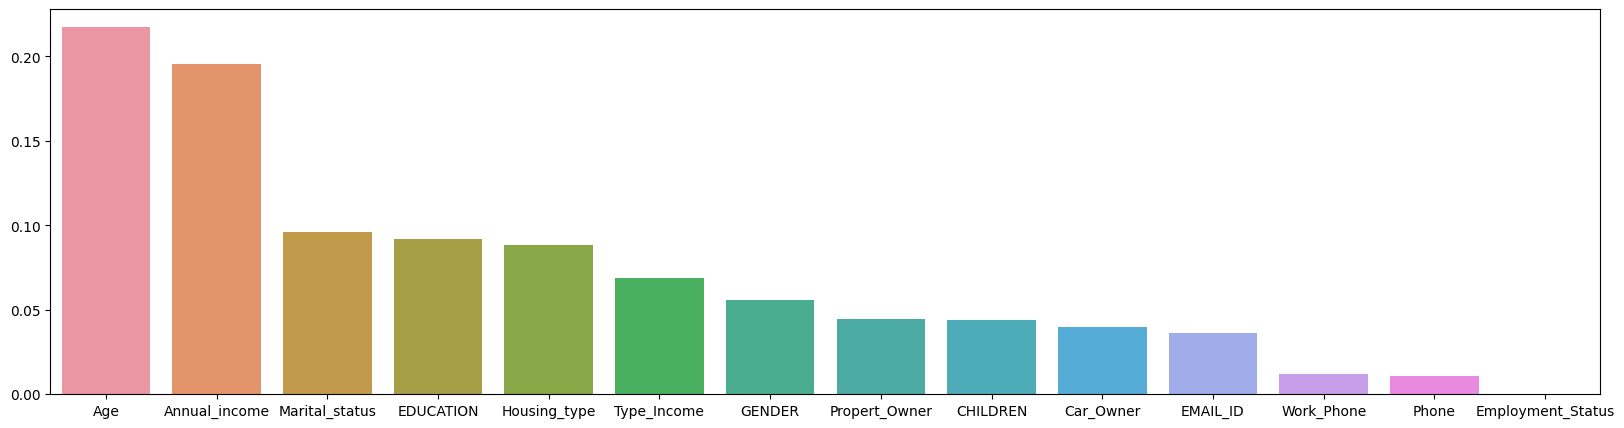

In [ ]:
features_dt = model_dt.best_estimator_.feature_importances_
col_names = df_x.columns
idx = features_dt.argsort()[::-1]
fna = col_names[idx]
fim = features_dt[idx]

plt.figure(figsize=(20,5))
sns.barplot(y=fim, x=fna)

# Random Forest & Boosting

In [ ]:
params_rf = {'randomforestclassifier__max_depth': [3, 5, 10, 15, 20],
          'randomforestclassifier__n_estimators': [30, 50, 100, 150, 200],
          'smote__k_neighbors': [3, 5, 7]}

rf = imb_make_pipeline(SMOTE(random_state=42), RandomForestClassifier())
model_rf = RandomizedSearchCV(estimator = rf, param_distributions = params_rf, cv=5)

model_rf.fit(x_train, y_train)

print(f'Validation data performance:', model_rf.score(x_val, y_val))
print(f'Test data performance:', model_rf.score(x_test, y_test))

Validation data performance: 0.9297658862876255
Test data performance: 0.92


In [ ]:
y_pred = model_rf.predict(x_test)
print(f1_score(y_pred, y_test))

0.45454545454545453


Evaluate Features for Random Forest Model

<Axes: >

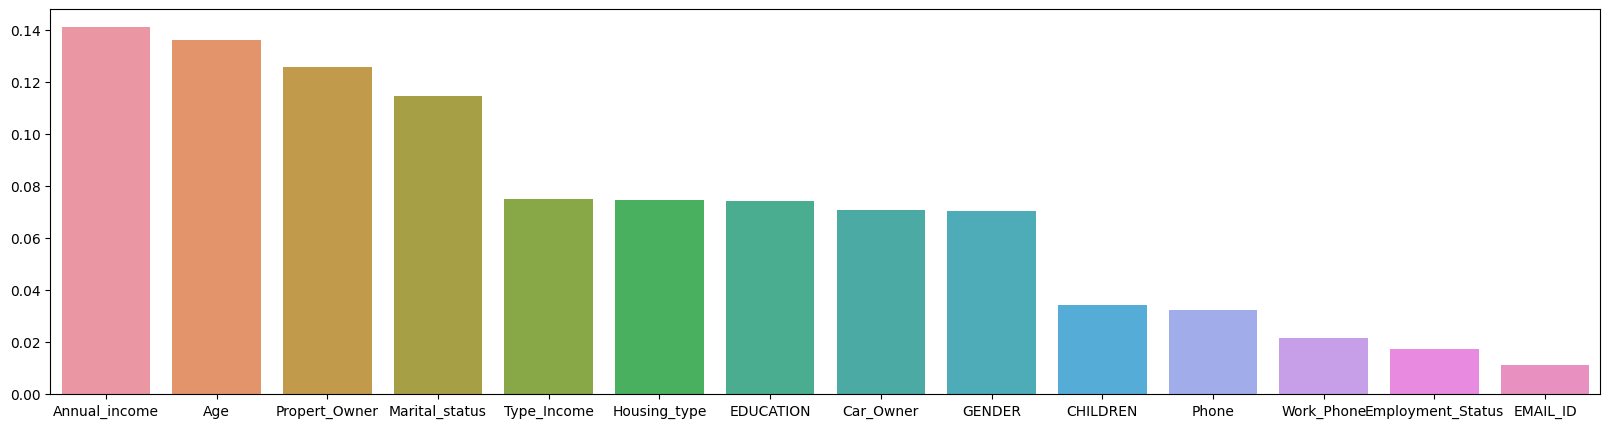

In [ ]:
features_rf = model_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
col_names = df_x.columns
idx = features_rf.argsort()[::-1]
fna = col_names[idx]
fim = features_rf[idx]

plt.figure(figsize=(20,5))
sns.barplot(y=fim, x=fna)

We can see that Age, Annual income, Propert_owner are the most important factors, which corresponds to our hypothesis and intuition.

A 92% testing accuracy is high, but we think this could be improved via boosting. We choose Catboost here since it is categorical value friendly

In [ ]:
param_catb = {
    'catboostclassifier__depth': [4, 6, 8, 10],
    'catboostclassifier__learning_rate' : [0.01, 0.05, 0.1],
    'catboostclassifier__iterations' : [30, 50, 100],
    'smote__k_neighbors': [3, 5, 7]
}

catb = imb_make_pipeline(SMOTE(random_state=42), CatBoostClassifier())
model_catb = RandomizedSearchCV(estimator=catb, param_distributions=param_catb, cv=5)
model_catb.fit(x_train, y_train)

0:	learn: 0.6661279	total: 13.3ms	remaining: 1.32s
1:	learn: 0.6411970	total: 22.5ms	remaining: 1.1s
2:	learn: 0.6176261	total: 29.8ms	remaining: 964ms
3:	learn: 0.5966568	total: 37.7ms	remaining: 905ms
4:	learn: 0.5750770	total: 50.1ms	remaining: 953ms
5:	learn: 0.5553751	total: 62.3ms	remaining: 975ms
6:	learn: 0.5381357	total: 69.4ms	remaining: 922ms
7:	learn: 0.5204483	total: 76.6ms	remaining: 880ms
8:	learn: 0.5050155	total: 83.6ms	remaining: 845ms
9:	learn: 0.4915818	total: 91.9ms	remaining: 827ms
10:	learn: 0.4787467	total: 99.1ms	remaining: 801ms
11:	learn: 0.4653431	total: 106ms	remaining: 779ms
12:	learn: 0.4524775	total: 118ms	remaining: 789ms
13:	learn: 0.4411023	total: 125ms	remaining: 770ms
14:	learn: 0.4298907	total: 133ms	remaining: 751ms
15:	learn: 0.4159579	total: 140ms	remaining: 733ms
16:	learn: 0.4069553	total: 148ms	remaining: 722ms
17:	learn: 0.4004058	total: 155ms	remaining: 707ms
18:	learn: 0.3909738	total: 163ms	remaining: 693ms
19:	learn: 0.3833417	total: 171

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('catboostclassifier',
                                              <catboost.core.CatBoostClassifier object at 0x7dd1830dfdc0>)]),
                   param_distributions={'catboostclassifier__depth': [4, 6, 8,
                                                                      10],
                                        'catboostclassifier__iterations': [30,
                                                                           50,
                                                                           100],
                                        'catboostclassifier__learning_rate': [0.01,
                                                                              0.05,
                                                                              0.1],
                                        'smote__k_neighbors': [3, 5, 7]})

We look at the feature importance and check its test score to see the performance.

<Axes: >

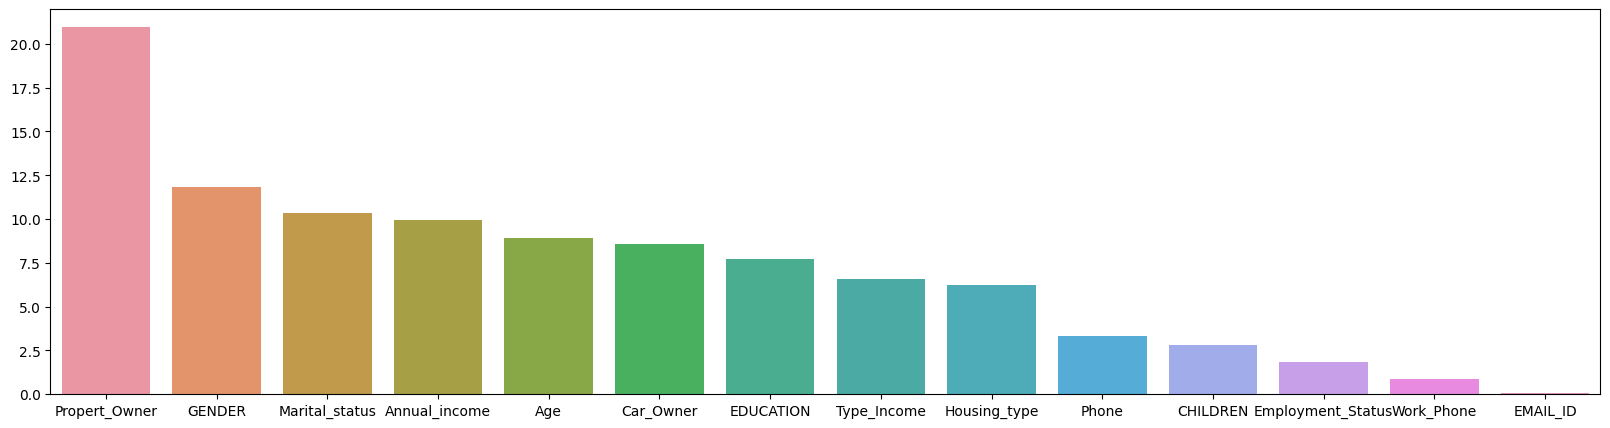

In [ ]:
features_catb = model_catb.best_estimator_.named_steps['catboostclassifier'].feature_importances_
col_names = df_x.columns
idx = features_catb.argsort()[::-1]
fna = col_names[idx]
fim = features_catb[idx]

plt.figure(figsize=(20,5))
sns.barplot(y=fim, x=fna)

In [ ]:
print(f'Validation data performance:', model_catb.score(x_val, y_val))
print(f'Test data performance:', model_catb.score(x_test, y_test))

y_pred = model_catb.predict(x_test)
print(f1_score(y_pred, y_test))

Validation data performance: 0.8762541806020067
Test data performance: 0.8733333333333333
0.17391304347826086


We can see the feature importance are different from Random Forest Model and Catboost provides a lower performance.

# Neural Network

Fit data for a nn model

In [ ]:
x_train_n = x_train.to_numpy()
y_train_n = y_train.to_numpy().reshape(-1,1)
x_val_n = x_val.to_numpy()
x_test_n = x_test.to_numpy()
y_val_n = y_val.to_numpy().reshape(-1,1)
y_test_n = y_test.to_numpy().reshape(-1,1)
ss = StandardScaler()
x_train_n = ss.fit_transform(x_train_n)
x_val_n = ss.transform(x_val_n)
x_test_n = ss.transform(x_test_n)

In [ ]:
# baseline model
model = Sequential([
    Dense(10,input_shape = (14,), activation='relu'),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])
opt = Adam(learning_rate=1e-3) #
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),])

history = model.fit(x_train_n,y_train_n, validation_data=(x_val_n, y_val_n),batch_size=32, epochs=50)

Epoch 1/50
29/29 [==============================] - 2s 16ms/step - loss: 0.6120 - accuracy: 0.7124 - precision: 0.1029 - recall: 0.2188 - val_loss: 0.4909 - val_accuracy: 0.8930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 0.5514 - accuracy: 0.8127 - precision: 0.1538 - recall: 0.1667 - val_loss: 0.4389 - val_accuracy: 0.8930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
29/29 [==============================] - 0s 5ms/step - loss: 0.4798 - accuracy: 0.8406 - precision: 0.1270 - recall: 0.0833 - val_loss: 0.4053 - val_accuracy: 0.8930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.4629 - accuracy: 0.8629 - precision: 0.1707 - recall: 0.0729 - val_loss: 0.3847 - val_accuracy: 0.8930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 0.4390 

Plot loss curve

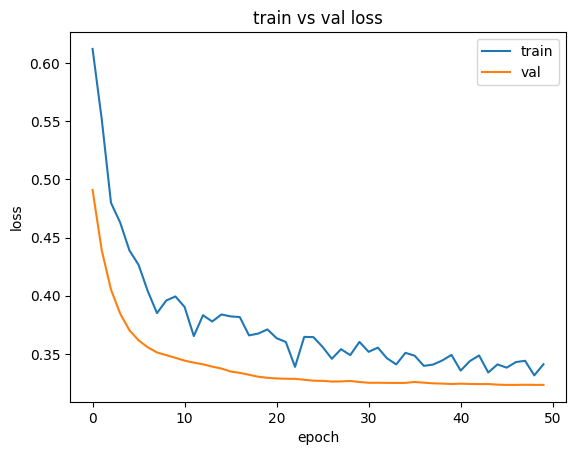

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train vs val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Evaluate the performance on test set

In [ ]:
score = model.evaluate(x_test_n,y_test_n,verbose=0)
print(model.metrics_names)
print(score)
# f1 score should be not applicable due to zero precision & recall

['loss', 'accuracy', 'precision', 'recall']
[0.36717694997787476, 0.8933333158493042, 0.0, 0.0]


Use class weight to deal with the imbalance in the dataset

In [ ]:
model2 = Sequential([
    Dense(10,input_shape = (14,), activation='relu'),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])
opt = Adam(learning_rate=1e-3) #
model2.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),])
weight = {0: 1., 1:8}
history = model2.fit(x_train_n,y_train_n, validation_data=(x_val_n, y_val_n),batch_size=32, epochs=50, class_weight=weight)

Epoch 1/50
29/29 [==============================] - 6s 43ms/step - loss: 1.3853 - accuracy: 0.5641 - precision: 0.0959 - recall: 0.3646 - val_loss: 0.6142 - val_accuracy: 0.7057 - val_precision: 0.1500 - val_recall: 0.3750
Epoch 2/50
29/29 [==============================] - 1s 20ms/step - loss: 1.3550 - accuracy: 0.4905 - precision: 0.0962 - recall: 0.4479 - val_loss: 0.6334 - val_accuracy: 0.6856 - val_precision: 0.1556 - val_recall: 0.4375
Epoch 3/50
29/29 [==============================] - 0s 14ms/step - loss: 1.3316 - accuracy: 0.4972 - precision: 0.1047 - recall: 0.4896 - val_loss: 0.6489 - val_accuracy: 0.6689 - val_precision: 0.1474 - val_recall: 0.4375
Epoch 4/50
29/29 [==============================] - 0s 16ms/step - loss: 1.2700 - accuracy: 0.5106 - precision: 0.1076 - recall: 0.4896 - val_loss: 0.6577 - val_accuracy: 0.6555 - val_precision: 0.1485 - val_recall: 0.4688
Epoch 5/50
29/29 [==============================] - 1s 18ms/step - loss: 1.2601 - accuracy: 0.5017 - precisi

Plot loss curve

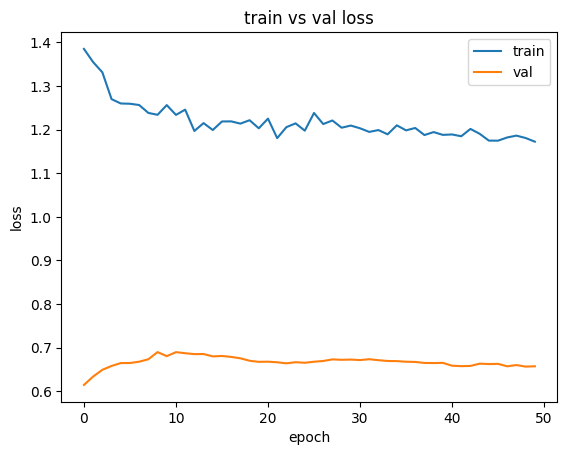

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train vs val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Evaluate the performance on test set

In [ ]:
score = model2.evaluate(x_test_n,y_test_n,verbose=0)
print(model2.metrics_names)
print(score)
print("f1 score: ",2 * (score[2] * score[3]) / (score[2] + score[3]))

['loss', 'accuracy', 'precision', 'recall']
[0.6620714068412781, 0.6600000262260437, 0.1111111119389534, 0.3125]
f1 score:  0.1639344271305459


We improved the F1 score by introducing class weight.








# Evaluation

In conclusion, we were able to build various different machine learning models to try to effectively predict whether a person’s credit card application will be approved based on various conditions. Due to the imbalance of the dataset, our goal was to maximize the F-1 score for each model. With fully tuned hyperparameters, our logistic regression F-1 score was 0.166 on the test data, our decision tree score F-1 was 0.486 on the test data, our SMOTE random forest F-1 score was 0.45 on the test data, and our neural network F-1 score was 0.16 on the test data. We can conclude that the decision tree was the best performing model on our dataset. \
In the future, if we were to continue fine tuning our models to achieve better performance, we would try tuning different hyperparameters for our neural network, or we could even try different types of neural networks. In this model, we tried a fully connected network with differing class weights which did not seem to give a reliable output on the test data. In future models, we might try changing the number of/type of layers, or use a network that is not fully connected. Other options for model optimization could be to continue fine tuning our decision tree or random forest models, since those were our best performing models.
